In [23]:
%load_ext autoreload
%autoreload 2

from aiida import load_profile
profile = load_profile()

import os
import numpy as np
import math as m
import pymatgen
import scipy.constants as cons
import matplotlib.pyplot as plt
from aiida.orm import load_node, Code, load_group, Group, WorkChainNode, Dict, StructureData
from aiida.engine import submit
from aiida_kkr.tools import find_parent_structure, plot_kkr, kkrparams, neworder_potential_wf
from aiida_kkr.calculations import KkrCalculation, VoronoiCalculation, KkrimpCalculation
from aiida_kkr.workflows import kkr_dos_wc, kkr_bs_wc, kkr_scf_wc, kkr_imp_sub_wc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
scf_lly = load_node('23b13d9d-6e02-46c7-b3ac-17033b205b19')
struc0 = find_parent_structure(scf_lly)
### Form here Checking for structure
dis_set= set()
dis_to_site_map= {}
for site in struc0.sites:
    pos= site.position
    dis = np.sqrt(np.sum([i**2 for i in pos]))
    dis_set.add(dis)
    dis_to_site_map[dis] = site
    
alat= 8.2826* 0.529#*10**(-10) Angstom
relative= 1
b_hor= 0.529*10**(-10)

for dis in dis_set:
    print(f"Site : {[ i*relative for i in dis_to_site_map[dis].position]}, kind name : {dis_to_site_map[dis].kind_name}, distance: {dis}")
struc0.attributes

BRAVAIS= [[-0.5, -0.2886751345, 2.3185997682],
  [0.5, -0.2886751345, 2.3185997682],
  [0.0, 0.577350269, 2.3185997682]],
BRAVAIS_arr= np.array([[-2.1907477 , -1.26482877, 10.15893422],
        [ 2.1907477 , -1.26482877, 10.15893422],
        [ 0.        ,  2.52965755, 10.15893422]])# Angstom



scf_lly.inputs.parameters.get_dict()
atom_list= [[0.0, 0.0, 0.0],
  [0.212, 0.212, 0.212],
  [-0.212, -0.212, -0.212],
  [0.4, 0.4, 0.4],
  [-0.4, -0.4, -0.4],
  [0.1, 0.1, 0.1],
  [-0.1, -0.1, -0.1],
  [0.3, 0.3, 0.3],
  [-0.3, -0.3, -0.3],
  [0.5, 0.5, 0.5]]
atom_arr= np.array(atom_list)*alat
atom_arr
calculated_site_list= []

for atom_pos in atom_list:
    calculated_site=0
#    print(f"atom_pos : {atom_pos}")
    i=0
    for cor in atom_pos:

        index = i%3
        i += 1
 
 #   print(BRAVAIS_arr[0,index,:]*cor) 

#        print(F"Index : {index},  BRAVAIS_arr : {BRAVAIS_arr[index,:]}")
#        calculated_site += BRAVAIS_arr[index,:]*cor
 #       print(calculated_site)
              
    calculated_site_list.append(calculated_site)
    
#calculated_site_list
atom_arr
alat

Site : [0.0, 0.0, 0.0], kind name : Te, distance: 0.0
Site : [-3.8809943008617e-17, 1.0071414359274e-16, 21.3409084951], kind name : HX, distance: 21.3409084951
Site : [2.1914815820078, 1.2652524812963, 22.357142232962], kind name : Bi, distance: 22.499894759544965
Site : [1.8747016921119e-16, 2.5305049625927, 23.373375970824], kind name : HX, distance: 23.509958733251725
Site : [-7.5181394577443e-17, -2.3960630364491e-17, 24.023765563056], kind name : Te, distance: 24.023765563056
Site : [2.1914815820078, 1.2652524812963, 25.405843446548], kind name : HX, distance: 25.531555702624388
Site : [-2.0670559458015e-16, 2.5305049625927, 26.78792133004], kind name : Te, distance: 26.90717719401495
Site : [-4.6526674632394e-17, 1.2427329655867e-16, 27.438310922272], kind name : HX, distance: 27.438310922272
Site : [2.1914815820078, 1.2652524812963, 28.454544660134], kind name : Bi, distance: 28.566843843541175
Site : [1.7975343758741e-16, 2.5305049625927, 29.470778397996], kind name : HX, dist

4.3814954

In [13]:
pym = struc0.get_pymatgen()
#pym.get_primitive_structure
pym

Structure Summary
Lattice
    abc : 10.472657559692419 10.472657559692419 10.472657559692438
 angles : 24.157680577616187 24.157680577616187 24.157680577615878
 volume : 169.06740315520517
      A : 2.1914815820078 1.2652524812963 10.162337378619
      B : -2.1914815820078 1.2652524812963 10.162337378619
      C : -8.1101110346236e-17 -2.5305049625927 10.162337378619
PeriodicSite: Te (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000]
PeriodicSite: Te (-0.0000, 2.5305, 26.7879) [1.2120, 1.2120, 0.2120]
PeriodicSite: Te (-0.0000, 0.0000, 24.0238) [0.7880, 0.7880, 0.7880]
PeriodicSite: Bi (2.1915, 1.2653, 22.3571) [1.4000, 0.4000, 0.4000]
PeriodicSite: Bi (2.1915, 1.2653, 28.4545) [1.6000, 0.6000, 0.6000]
PeriodicSite:  (-0.0000, 2.5305, 23.3734) [1.1000, 1.1000, 0.1000]
PeriodicSite:  (-0.0000, 0.0000, 27.4383) [0.9000, 0.9000, 0.9000]
PeriodicSite:  (-0.0000, 2.5305, 29.4708) [1.3000, 1.3000, 0.3000]
PeriodicSite:  (-0.0000, 0.0000, 21.3409) [0.7000, 0.7000, 0.7000]
PeriodicSite:  (2.191

In [14]:
li1= [2.1914815820078, 1.2652524812963, 10.162337378619]
alat= np.sqrt(np.sum([i**2 for i in li1]))
alat*(3)**(1/3)
15.10*1.6

24.16

In [15]:
from pymatgen.core import Lattice, Structure, Molecule
original_cell = [
                 [2.1914815820078, 1.2652524812963, 10.162337378619],
                 [-2.1914815820078, 1.2652524812963, 10.162337378619],
                 [-8.1101110346236e-17, -2.5305049625927, 10.162337378619]
                ]

z= original_cell[2]

for i in range(len(original_cell)-1):
    original_cell[i]= list(np.array(original_cell[i])- np.array(z))

original_cell

latice = Lattice(original_cell)

atom_coordinates = [[0.0, 0.0, 0.0],
                   [0.30, 0.50, 0.2],
                   [0.30, 0.25, 0.45],
                   [0.60, 0.50, 0.65],
                   [0.30, 0.30, 0.8]]
struc = Structure(latice, ['Te', 'Bi', 'Te', 'Bi', 'Te'], atom_coordinates)
original_cell

[[2.1914815820078, 3.795757443889, 0.0],
 [-2.1914815820078, 3.795757443889, 0.0],
 [-8.1101110346236e-17, -2.5305049625927, 10.162337378619]]

In [17]:
#struc

In [18]:
.3*-1.919999999999999 + 0.9000*3.84


2.8800000000000003

In [54]:
#To colloect the Jij Data
accending_distance_group = [104,102, 118, 115 ]

3 3


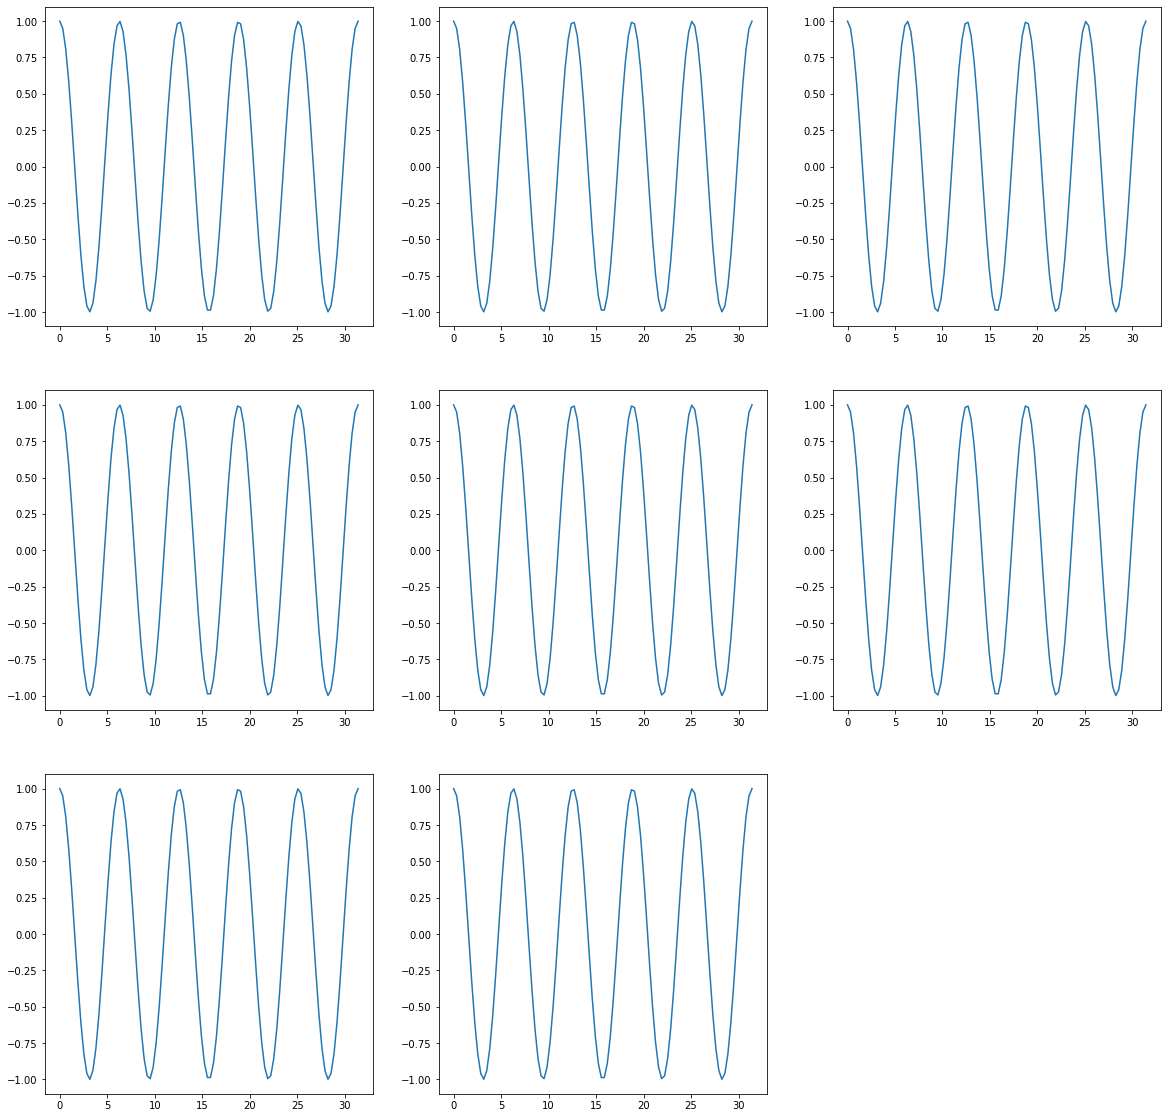

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as m

flights = sns.load_dataset("flights")
flights.head()
may_flights = flights.query("month == 'May'")

number_of_plot = 8

plt.figure(figsize=(20,20))
row, col = (3, 3)
print(row, col)

figure_index = 0

for fig_cor_row in range(row):
    for fig_cor_col in range(col):
        figure_index += 1
        if figure_index > number_of_plot:
            continue
        plt.subplot(row, col, figure_index)
        plt.plot(x, y)
    

In [28]:
may_flights

,year,month,passengers
4,1949,May,121
16,1950,May,125
28,1951,May,172
40,1952,May,183
52,1953,May,229
64,1954,May,234
76,1955,May,270
88,1956,May,318
100,1957,May,355
112,1958,May,363


In [22]:
ll=node_16195.inputs.remote_data_gf.get_incoming(node_class=KkrCalculation).all()[0].node
#ll.inputs.parameters.get_dict()